### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [1]:
# #
# import sys
# #
# from google.colab import drive
# #
# drive.mount('/content/drive')
# #
# sys.path.append('/content/drive/MyDrive/IntProject')

In [2]:

# import sys
#
# del sys.modules['data_func']
# del sys.modules['utils']
# del sys.modules['model']


In [3]:
# pip install yeoda

In [4]:
# pip install tifftools

In [3]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# pip install tqdm

In [5]:
# pip install torchvision

### Data Preparation & Augmentation

In [6]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 1

In [7]:
train_transform = A.Compose([
     
    A.Resize(256, 256),
    A.RandomResizedCrop(256, 256, scale=(0.3, 0.5), p=0.5),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
], )


In [8]:

run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask', './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                             './drive/MyDrive/IntProject/test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './drive/MyDrive/IntProject/model_results2.txt'
    model_file = './drive/MyDrive/IntProject/model2.pt'
else:
    train_set = ImageDataset('./train/', './train_mask', './train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./val/', './val_mask', './val_mask_lacken', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./test/', './test_mask', './test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './model_results2.txt'
    model_file = './model2.pt'


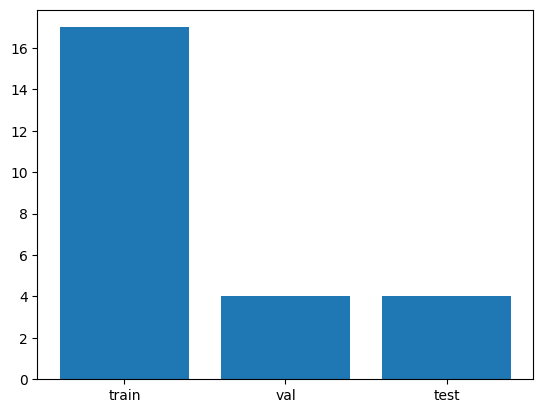

In [9]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

In [10]:
image, mask, lacken_mask = train_set[1]

TypeError: cannot unpack non-iterable NoneType object

In [11]:
train_set

TypeError: cannot unpack non-iterable NoneType object

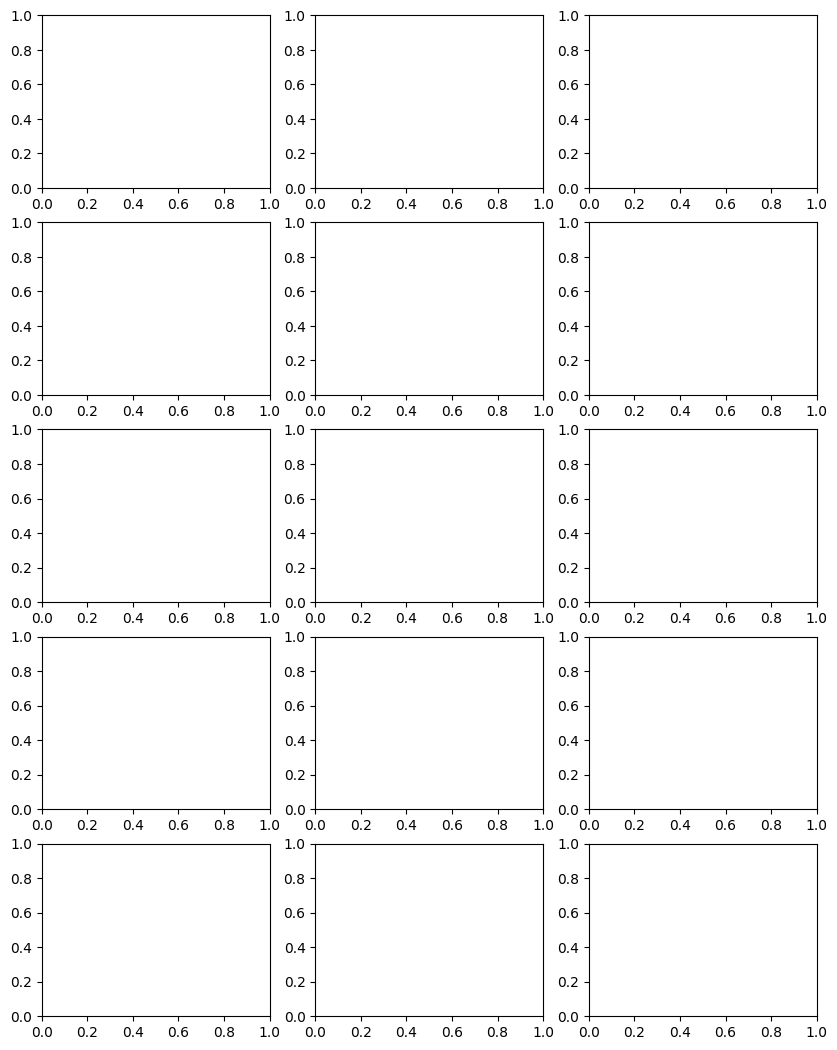

In [12]:
visualize_augmentations(train_set, idx=1, samples=5)


#### Train & Evaluate

In [28]:
epochs = 50
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
grad_scaler = torch.cuda.amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
global_step = 0

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_1254/4017127355.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler()


In [30]:

def train_evaluate(model, epochs, trainloader, valloader, optimizer, criterion, grad_scaler, scheduler, dict_file,
                   model_file, best_dice=0, patience=10):
    train_losses, val_losses = [], []
    train_dices, train_l_dices, val_dices, val_l_dices = [], [], [], []
    train_ious, train_l_ious, val_ious, val_l_ious = [], [], [], []
    train_accs, train_l_accs, val_accs, val_l_accs = [], [], [], []
    for epoch in tqdm(range(epochs)):
        ###################
        # train the model #
        ###################
        model.train()
        lake_loss = 0
        lacken_loss = 0
        train_loss = 0
        train_dice = 0
        train_iou = 0
        train_acc = 0
        train_l_acc = 0
        train_l_dice = 0
        train_l_iou = 0

        for i, (images, masks, lacken_masks) in enumerate(trainloader):
            images, masks, lacken_masks = images.to(device), masks.to(device), lacken_masks.to(device)
            logits = model(images)
            lake_loss =  criterion(logits, masks.float())
            lake_loss  += 2 * dice_loss(F.sigmoid(logits), masks.float())
            lacken_loss = criterion(logits, lacken_masks.float())
            loss = lake_loss + lacken_loss * 2

            optimizer.zero_grad()
            grad_scaler.scale(loss).backward()
            grad_scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            grad_scaler.step(optimizer)
            grad_scaler.update()
            mask_pred = (F.sigmoid(logits) > 0.5).float()

            train_loss += loss.item()
            train_dice += dice_coeff(mask_pred, masks)
            train_l_dice += dice_coeff(mask_pred, lacken_masks)
            train_iou += iou(mask_pred, masks)
            train_l_iou += iou(mask_pred, lacken_masks)
            train_acc += pixel_accuracy(mask_pred, masks)
            train_l_acc += pixel_accuracy(mask_pred, lacken_masks)

        train_loss /= len(trainloader)
        train_dice /= len(trainloader)
        train_iou /= len(trainloader)
        train_acc /= len(trainloader)
        train_l_acc /= len(trainloader)
        train_l_dice /= len(trainloader)
        train_l_iou /= len(trainloader)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        train_ious.append(train_iou)
        train_accs.append(train_acc)
        train_l_accs.append(train_l_acc)
        train_l_ious.append(train_l_iou)
        train_l_dices.append(train_l_dice)

        ######################
        # validate the model #
        ######################
        model.eval()
        lake_loss = 0
        lacken_loss = 0
        val_loss = 0
        val_dice = 0
        val_iou = 0
        val_acc = 0
        val_l_dice = 0
        val_l_iou = 0
        val_l_acc = 0
        with torch.no_grad():
            for i, (images, masks, lacken_masks) in enumerate(valloader):
                images, masks, lacken_masks = images.to(device), masks.to(device), lacken_masks.to(device)
                logits = model(images)
                # loss = criterion(logits, masks.float())
                # 
                # mask_pred = (F.sigmoid(logits) > 0.5).float()
                # loss += dice_loss(F.sigmoid(logits), masks.float())
                
                lake_loss =  criterion(logits, masks.float())
                lake_loss  += 2 * dice_loss(mask_pred, masks.float())
                lacken_loss = criterion(logits, lacken_masks.float())
                loss = lake_loss + lacken_loss *2    
                val_loss += loss.item()
                val_dice += dice_coeff(mask_pred, masks)
                val_l_dice += dice_coeff(mask_pred, lacken_masks)
                val_iou += iou(mask_pred, masks)
                val_l_iou += iou(mask_pred, lacken_masks)
                val_acc += pixel_accuracy(mask_pred, masks)
                val_l_acc += pixel_accuracy(mask_pred, lacken_masks)
        scheduler.step(val_dice)
        val_loss /= len(valloader)
        val_dice /= len(valloader)
        val_iou /= len(valloader)
        val_acc /= len(valloader)
        val_l_acc /= len(valloader)
        val_l_dice /= len(valloader)
        val_l_iou /= len(valloader)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        val_accs.append(val_acc)
        val_l_accs.append(val_l_acc)
        val_l_dices.append(val_l_dice)
        val_l_ious.append(val_l_iou)

        print(f" \n Epoch: {epoch + 1} ")
        print(
            f"TRAIN FUll: Train Loss: {train_loss:.4f} | Train DICE Coeff: {train_dice:.4f}  | Train IoU Coeff: {train_iou:.4f}|  | Train Accuracy: {train_acc * 100:.2f} ")
        print(
            f"TRAIN LACKENS: Train DICE Coeff: {train_l_dice:.4f}  | Train IoU Coeff: {train_l_iou:.4f}|  | Train Accuracy: {train_l_acc * 100:.2f} ")
        print(
            f"VAL FULL: Val Loss: {val_loss:.4f} | Val DICE Coeff: {val_dice:.4f} | Val IoU Coeff: {val_iou:.4f}| Val Accuracy: {val_acc * 100:.2f}| ")
        print(
            f"VAL LACKENS: Val DICE Coeff: {val_l_dice:.4f} | Val IoU Coeff: {val_l_iou:.4f}| Val Accuracy: {val_l_acc * 100:.2f}| ")

        d = {'epoch': epoch, 'train loss': train_loss, 'valid loss': val_loss, 'train_dice': train_dice,
             'train_l_dice': train_l_dice, 'val_dice': val_dice, 'val_l_dice': val_l_dice}

        with open(dict_file, 'a') as f:
            dictwriter_object = DictWriter(f,
                                           fieldnames=['epoch', 'train loss', 'valid loss', 'train_dice',
                                                       'train_l_dice', 'val_dice',
                                                       'val_l_dice'])
            dictwriter_object.writerow(d)

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), model_file)


In [31]:

train_evaluate(model, epochs, trainloader, valloader, optimizer, criterion, grad_scaler, scheduler, dict_file,
               model_file, best_dice=0, patience=10)

  2%|▏         | 1/50 [00:42<34:22, 42.08s/it]

 
 Epoch: 1 
TRAIN FUll: Train Loss: 4.0974 | Train DICE Coeff: 0.0313  | Train IoU Coeff: 0.0076|  | Train Accuracy: 50.14 
TRAIN LACKENS: Train DICE Coeff: 0.0016  | Train IoU Coeff: 0.0006|  | Train Accuracy: 50.13 
VAL FULL: Val Loss: 3.9236 | Val DICE Coeff: 0.0220 | Val IoU Coeff: 0.0105| Val Accuracy: 80.36| 
VAL LACKENS: Val DICE Coeff: 0.0005 | Val IoU Coeff: 0.0002| Val Accuracy: 80.92| 


  4%|▍         | 2/50 [01:22<33:06, 41.39s/it]

 
 Epoch: 2 
TRAIN FUll: Train Loss: 3.4893 | Train DICE Coeff: 0.0877  | Train IoU Coeff: 0.0530|  | Train Accuracy: 94.23 
TRAIN LACKENS: Train DICE Coeff: 0.0029  | Train IoU Coeff: 0.0012|  | Train Accuracy: 94.61 
VAL FULL: Val Loss: 4.1488 | Val DICE Coeff: 0.0069 | Val IoU Coeff: 0.0042| Val Accuracy: 95.49| 
VAL LACKENS: Val DICE Coeff: 0.0005 | Val IoU Coeff: 0.0001| Val Accuracy: 96.61| 


  6%|▌         | 3/50 [02:04<32:26, 41.40s/it]

 
 Epoch: 3 
TRAIN FUll: Train Loss: 3.2371 | Train DICE Coeff: 0.0264  | Train IoU Coeff: 0.0157|  | Train Accuracy: 98.30 
TRAIN LACKENS: Train DICE Coeff: 0.0038  | Train IoU Coeff: 0.0010|  | Train Accuracy: 99.20 
VAL FULL: Val Loss: 3.5430 | Val DICE Coeff: 0.0007 | Val IoU Coeff: 0.0002| Val Accuracy: 97.75| 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0004| Val Accuracy: 99.15| 


  8%|▊         | 4/50 [09:36<2:36:05, 203.61s/it]

 
 Epoch: 4 
TRAIN FUll: Train Loss: 3.1089 | Train DICE Coeff: 0.1197  | Train IoU Coeff: 0.1349|  | Train Accuracy: 98.85 
TRAIN LACKENS: Train DICE Coeff: 0.0208  | Train IoU Coeff: 0.0016|  | Train Accuracy: 99.63 
VAL FULL: Val Loss: 3.7304 | Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0002| Val Accuracy: 98.42| 
VAL LACKENS: Val DICE Coeff: 0.0307 | Val IoU Coeff: 0.0016| Val Accuracy: 99.77| 


 10%|█         | 5/50 [10:18<1:48:50, 145.13s/it]

 
 Epoch: 5 
TRAIN FUll: Train Loss: 3.0209 | Train DICE Coeff: 0.0122  | Train IoU Coeff: 0.0050|  | Train Accuracy: 99.08 
TRAIN LACKENS: Train DICE Coeff: 0.0429  | Train IoU Coeff: 0.0078|  | Train Accuracy: 99.85 
VAL FULL: Val Loss: 3.5748 | Val DICE Coeff: 0.0020 | Val IoU Coeff: 0.0003| Val Accuracy: 98.84| 
VAL LACKENS: Val DICE Coeff: 0.0836 | Val IoU Coeff: 0.0130| Val Accuracy: 99.97| 


 12%|█▏        | 6/50 [16:27<2:42:24, 221.48s/it]

 
 Epoch: 6 
TRAIN FUll: Train Loss: 2.9188 | Train DICE Coeff: 0.0024  | Train IoU Coeff: 0.0004|  | Train Accuracy: 99.05 
TRAIN LACKENS: Train DICE Coeff: 0.0510  | Train IoU Coeff: 0.0067|  | Train Accuracy: 99.94 
VAL FULL: Val Loss: 2.7924 | Val DICE Coeff: 0.0027 | Val IoU Coeff: 0.0004| Val Accuracy: 99.04| 
VAL LACKENS: Val DICE Coeff: 0.0762 | Val IoU Coeff: 0.0196| Val Accuracy: 99.98| 


 14%|█▍        | 7/50 [17:08<1:56:24, 162.43s/it]

 
 Epoch: 7 
TRAIN FUll: Train Loss: 2.8283 | Train DICE Coeff: 0.0831  | Train IoU Coeff: 0.0630|  | Train Accuracy: 98.97 
TRAIN LACKENS: Train DICE Coeff: 0.0655  | Train IoU Coeff: 0.0061|  | Train Accuracy: 99.85 
VAL FULL: Val Loss: 2.2578 | Val DICE Coeff: 0.1414 | Val IoU Coeff: 0.0052| Val Accuracy: 98.84| 
VAL LACKENS: Val DICE Coeff: 0.1344 | Val IoU Coeff: 0.0010| Val Accuracy: 99.62| 


 16%|█▌        | 8/50 [17:48<1:26:28, 123.53s/it]

 
 Epoch: 8 
TRAIN FUll: Train Loss: 2.7722 | Train DICE Coeff: 0.0762  | Train IoU Coeff: 0.0544|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0432  | Train IoU Coeff: 0.0053|  | Train Accuracy: 99.91 
VAL FULL: Val Loss: 2.7132 | Val DICE Coeff: 0.0026 | Val IoU Coeff: 0.0003| Val Accuracy: 98.89| 
VAL LACKENS: Val DICE Coeff: 0.0784 | Val IoU Coeff: 0.0045| Val Accuracy: 99.92| 


 18%|█▊        | 9/50 [18:30<1:06:48, 97.77s/it] 

 
 Epoch: 9 
TRAIN FUll: Train Loss: 2.7143 | Train DICE Coeff: 0.1927  | Train IoU Coeff: 0.1575|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0462  | Train IoU Coeff: 0.0066|  | Train Accuracy: 99.78 
VAL FULL: Val Loss: 2.7268 | Val DICE Coeff: 0.0017 | Val IoU Coeff: 0.0004| Val Accuracy: 98.93| 
VAL LACKENS: Val DICE Coeff: 0.0730 | Val IoU Coeff: 0.0085| Val Accuracy: 99.96| 


 20%|██        | 10/50 [35:28<4:14:44, 382.10s/it]

 
 Epoch: 10 
TRAIN FUll: Train Loss: 2.6687 | Train DICE Coeff: 0.1382  | Train IoU Coeff: 0.1600|  | Train Accuracy: 99.23 
TRAIN LACKENS: Train DICE Coeff: 0.0418  | Train IoU Coeff: 0.0039|  | Train Accuracy: 99.77 
VAL FULL: Val Loss: 2.1743 | Val DICE Coeff: 0.2516 | Val IoU Coeff: 0.0007| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.3679 | Val IoU Coeff: 0.0455| Val Accuracy: 99.99| 


 22%|██▏       | 11/50 [36:11<3:00:56, 278.38s/it]

 
 Epoch: 11 
TRAIN FUll: Train Loss: 2.5955 | Train DICE Coeff: 0.1795  | Train IoU Coeff: 0.1447|  | Train Accuracy: 99.14 
TRAIN LACKENS: Train DICE Coeff: 0.0418  | Train IoU Coeff: 0.0052|  | Train Accuracy: 99.78 
VAL FULL: Val Loss: 2.2925 | Val DICE Coeff: 0.1839 | Val IoU Coeff: 0.0578| Val Accuracy: 98.39| 
VAL LACKENS: Val DICE Coeff: 0.0087 | Val IoU Coeff: 0.0007| Val Accuracy: 99.46| 


 24%|██▍       | 12/50 [36:53<2:10:43, 206.40s/it]

 
 Epoch: 12 
TRAIN FUll: Train Loss: 2.5390 | Train DICE Coeff: 0.2609  | Train IoU Coeff: 0.2045|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0535  | Train IoU Coeff: 0.0156|  | Train Accuracy: 99.68 
VAL FULL: Val Loss: 2.6379 | Val DICE Coeff: 0.0065 | Val IoU Coeff: 0.0039| Val Accuracy: 97.66| 
VAL LACKENS: Val DICE Coeff: 0.0332 | Val IoU Coeff: 0.0006| Val Accuracy: 99.38| 


 26%|██▌       | 13/50 [37:36<1:36:46, 156.92s/it]

 
 Epoch: 13 
TRAIN FUll: Train Loss: 2.4968 | Train DICE Coeff: 0.1902  | Train IoU Coeff: 0.2026|  | Train Accuracy: 99.04 
TRAIN LACKENS: Train DICE Coeff: 0.0525  | Train IoU Coeff: 0.0220|  | Train Accuracy: 99.55 
VAL FULL: Val Loss: 2.4587 | Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0002| Val Accuracy: 98.21| 
VAL LACKENS: Val DICE Coeff: 0.0459 | Val IoU Coeff: 0.0098| Val Accuracy: 99.96| 


 28%|██▊       | 14/50 [38:19<1:13:22, 122.30s/it]

 
 Epoch: 14 
TRAIN FUll: Train Loss: 2.4583 | Train DICE Coeff: 0.1591  | Train IoU Coeff: 0.1545|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0469  | Train IoU Coeff: 0.0046|  | Train Accuracy: 99.84 
VAL FULL: Val Loss: 2.5817 | Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0002| Val Accuracy: 98.45| 
VAL LACKENS: Val DICE Coeff: 0.0599 | Val IoU Coeff: 0.0049| Val Accuracy: 99.69| 


 30%|███       | 15/50 [39:00<57:10, 98.03s/it]   

 
 Epoch: 15 
TRAIN FUll: Train Loss: 2.4093 | Train DICE Coeff: 0.2654  | Train IoU Coeff: 0.1942|  | Train Accuracy: 99.32 
TRAIN LACKENS: Train DICE Coeff: 0.0915  | Train IoU Coeff: 0.0023|  | Train Accuracy: 99.82 
VAL FULL: Val Loss: 2.3985 | Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0002| Val Accuracy: 98.44| 
VAL LACKENS: Val DICE Coeff: 0.0139 | Val IoU Coeff: 0.0023| Val Accuracy: 99.83| 


 32%|███▏      | 16/50 [39:41<45:44, 80.71s/it]

 
 Epoch: 16 
TRAIN FUll: Train Loss: 2.3518 | Train DICE Coeff: 0.1831  | Train IoU Coeff: 0.1355|  | Train Accuracy: 99.12 
TRAIN LACKENS: Train DICE Coeff: 0.0319  | Train IoU Coeff: 0.0057|  | Train Accuracy: 99.79 
VAL FULL: Val Loss: 2.4638 | Val DICE Coeff: 0.0013 | Val IoU Coeff: 0.0003| Val Accuracy: 98.55| 
VAL LACKENS: Val DICE Coeff: 0.0670 | Val IoU Coeff: 0.0022| Val Accuracy: 99.83| 


 34%|███▍      | 17/50 [40:22<37:50, 68.81s/it]

 
 Epoch: 17 
TRAIN FUll: Train Loss: 2.3376 | Train DICE Coeff: 0.3456  | Train IoU Coeff: 0.2780|  | Train Accuracy: 99.36 
TRAIN LACKENS: Train DICE Coeff: 0.0450  | Train IoU Coeff: 0.0100|  | Train Accuracy: 99.57 
VAL FULL: Val Loss: 2.4247 | Val DICE Coeff: 0.0028 | Val IoU Coeff: 0.0011| Val Accuracy: 98.99| 
VAL LACKENS: Val DICE Coeff: 0.0198 | Val IoU Coeff: 0.0012| Val Accuracy: 99.69| 


 36%|███▌      | 18/50 [41:09<33:10, 62.20s/it]

 
 Epoch: 18 
TRAIN FUll: Train Loss: 2.3216 | Train DICE Coeff: 0.2344  | Train IoU Coeff: 0.2012|  | Train Accuracy: 99.16 
TRAIN LACKENS: Train DICE Coeff: 0.0430  | Train IoU Coeff: 0.0030|  | Train Accuracy: 99.69 
VAL FULL: Val Loss: 2.3671 | Val DICE Coeff: 0.0190 | Val IoU Coeff: 0.0136| Val Accuracy: 98.59| 
VAL LACKENS: Val DICE Coeff: 0.0976 | Val IoU Coeff: 0.0054| Val Accuracy: 99.86| 


 38%|███▊      | 19/50 [41:52<29:10, 56.46s/it]

 
 Epoch: 19 
TRAIN FUll: Train Loss: 2.2927 | Train DICE Coeff: 0.3125  | Train IoU Coeff: 0.2622|  | Train Accuracy: 99.19 
TRAIN LACKENS: Train DICE Coeff: 0.0263  | Train IoU Coeff: 0.0049|  | Train Accuracy: 99.54 
VAL FULL: Val Loss: 2.2786 | Val DICE Coeff: 0.0651 | Val IoU Coeff: 0.0248| Val Accuracy: 98.93| 
VAL LACKENS: Val DICE Coeff: 0.0151 | Val IoU Coeff: 0.0017| Val Accuracy: 99.78| 


 40%|████      | 20/50 [42:35<26:16, 52.55s/it]

 
 Epoch: 20 
TRAIN FUll: Train Loss: 2.3175 | Train DICE Coeff: 0.3498  | Train IoU Coeff: 0.2693|  | Train Accuracy: 99.35 
TRAIN LACKENS: Train DICE Coeff: 0.0156  | Train IoU Coeff: 0.0095|  | Train Accuracy: 99.62 
VAL FULL: Val Loss: 2.5194 | Val DICE Coeff: 0.0015 | Val IoU Coeff: 0.0005| Val Accuracy: 98.41| 
VAL LACKENS: Val DICE Coeff: 0.0203 | Val IoU Coeff: 0.0013| Val Accuracy: 99.71| 


 42%|████▏     | 21/50 [43:16<23:37, 48.88s/it]

 
 Epoch: 21 
TRAIN FUll: Train Loss: 2.3049 | Train DICE Coeff: 0.4032  | Train IoU Coeff: 0.3376|  | Train Accuracy: 99.32 
TRAIN LACKENS: Train DICE Coeff: 0.0256  | Train IoU Coeff: 0.0059|  | Train Accuracy: 99.54 
VAL FULL: Val Loss: 2.4086 | Val DICE Coeff: 0.0014 | Val IoU Coeff: 0.0003| Val Accuracy: 98.71| 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0010| Val Accuracy: 99.64| 


 44%|████▍     | 22/50 [43:56<21:36, 46.30s/it]

 
 Epoch: 22 
TRAIN FUll: Train Loss: 2.2948 | Train DICE Coeff: 0.3691  | Train IoU Coeff: 0.3188|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0111  | Train IoU Coeff: 0.0018|  | Train Accuracy: 99.59 
VAL FULL: Val Loss: 2.4224 | Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0002| Val Accuracy: 98.15| 
VAL LACKENS: Val DICE Coeff: 0.0869 | Val IoU Coeff: 0.0011| Val Accuracy: 99.66| 


 46%|████▌     | 23/50 [44:36<20:02, 44.55s/it]

 
 Epoch: 23 
TRAIN FUll: Train Loss: 2.2823 | Train DICE Coeff: 0.3367  | Train IoU Coeff: 0.2765|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0430  | Train IoU Coeff: 0.0093|  | Train Accuracy: 99.56 
VAL FULL: Val Loss: 2.3909 | Val DICE Coeff: 0.0015 | Val IoU Coeff: 0.0003| Val Accuracy: 98.59| 
VAL LACKENS: Val DICE Coeff: 0.0264 | Val IoU Coeff: 0.0015| Val Accuracy: 99.75| 


 48%|████▊     | 24/50 [45:17<18:43, 43.22s/it]

 
 Epoch: 24 
TRAIN FUll: Train Loss: 2.3072 | Train DICE Coeff: 0.2868  | Train IoU Coeff: 0.2700|  | Train Accuracy: 99.36 
TRAIN LACKENS: Train DICE Coeff: 0.0278  | Train IoU Coeff: 0.0120|  | Train Accuracy: 99.70 
VAL FULL: Val Loss: 2.4156 | Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0002| Val Accuracy: 98.32| 
VAL LACKENS: Val DICE Coeff: 0.0302 | Val IoU Coeff: 0.0014| Val Accuracy: 99.74| 


 50%|█████     | 25/50 [45:57<17:36, 42.24s/it]

 
 Epoch: 25 
TRAIN FUll: Train Loss: 2.3023 | Train DICE Coeff: 0.2557  | Train IoU Coeff: 0.2349|  | Train Accuracy: 99.38 
TRAIN LACKENS: Train DICE Coeff: 0.0275  | Train IoU Coeff: 0.0020|  | Train Accuracy: 99.76 
VAL FULL: Val Loss: 2.3504 | Val DICE Coeff: 0.0066 | Val IoU Coeff: 0.0033| Val Accuracy: 98.97| 
VAL LACKENS: Val DICE Coeff: 0.0213 | Val IoU Coeff: 0.0012| Val Accuracy: 99.67| 


 52%|█████▏    | 26/50 [46:37<16:39, 41.63s/it]

 
 Epoch: 26 
TRAIN FUll: Train Loss: 2.2802 | Train DICE Coeff: 0.2887  | Train IoU Coeff: 0.2219|  | Train Accuracy: 99.12 
TRAIN LACKENS: Train DICE Coeff: 0.0236  | Train IoU Coeff: 0.0082|  | Train Accuracy: 99.62 
VAL FULL: Val Loss: 2.3635 | Val DICE Coeff: 0.0015 | Val IoU Coeff: 0.0004| Val Accuracy: 98.92| 
VAL LACKENS: Val DICE Coeff: 0.0485 | Val IoU Coeff: 0.0025| Val Accuracy: 99.85| 


 54%|█████▍    | 27/50 [47:17<15:46, 41.16s/it]

 
 Epoch: 27 
TRAIN FUll: Train Loss: 2.2691 | Train DICE Coeff: 0.3152  | Train IoU Coeff: 0.2324|  | Train Accuracy: 98.99 
TRAIN LACKENS: Train DICE Coeff: 0.0283  | Train IoU Coeff: 0.0045|  | Train Accuracy: 99.53 
VAL FULL: Val Loss: 2.0415 | Val DICE Coeff: 0.1694 | Val IoU Coeff: 0.0751| Val Accuracy: 98.87| 
VAL LACKENS: Val DICE Coeff: 0.0209 | Val IoU Coeff: 0.0017| Val Accuracy: 99.78| 


 56%|█████▌    | 28/50 [47:57<15:02, 41.00s/it]

 
 Epoch: 28 
TRAIN FUll: Train Loss: 2.3052 | Train DICE Coeff: 0.2601  | Train IoU Coeff: 0.2480|  | Train Accuracy: 99.19 
TRAIN LACKENS: Train DICE Coeff: 0.0273  | Train IoU Coeff: 0.0125|  | Train Accuracy: 99.59 
VAL FULL: Val Loss: 2.4068 | Val DICE Coeff: 0.0036 | Val IoU Coeff: 0.0013| Val Accuracy: 98.58| 
VAL LACKENS: Val DICE Coeff: 0.0145 | Val IoU Coeff: 0.0012| Val Accuracy: 99.67| 


 58%|█████▊    | 29/50 [48:38<14:20, 40.95s/it]

 
 Epoch: 29 
TRAIN FUll: Train Loss: 2.2906 | Train DICE Coeff: 0.2692  | Train IoU Coeff: 0.2331|  | Train Accuracy: 99.13 
TRAIN LACKENS: Train DICE Coeff: 0.0222  | Train IoU Coeff: 0.0030|  | Train Accuracy: 99.61 
VAL FULL: Val Loss: 2.4069 | Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0002| Val Accuracy: 98.32| 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0007| Val Accuracy: 99.45| 


 60%|██████    | 30/50 [49:19<13:38, 40.92s/it]

 
 Epoch: 30 
TRAIN FUll: Train Loss: 2.2924 | Train DICE Coeff: 0.3328  | Train IoU Coeff: 0.3039|  | Train Accuracy: 99.25 
TRAIN LACKENS: Train DICE Coeff: 0.0325  | Train IoU Coeff: 0.0085|  | Train Accuracy: 99.60 
VAL FULL: Val Loss: 2.4118 | Val DICE Coeff: 0.0075 | Val IoU Coeff: 0.0021| Val Accuracy: 97.85| 
VAL LACKENS: Val DICE Coeff: 0.0360 | Val IoU Coeff: 0.0072| Val Accuracy: 99.63| 


 62%|██████▏   | 31/50 [50:00<12:56, 40.89s/it]

 
 Epoch: 31 
TRAIN FUll: Train Loss: 2.2654 | Train DICE Coeff: 0.3218  | Train IoU Coeff: 0.3275|  | Train Accuracy: 99.04 
TRAIN LACKENS: Train DICE Coeff: 0.0481  | Train IoU Coeff: 0.0133|  | Train Accuracy: 99.33 
VAL FULL: Val Loss: 2.3963 | Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0002| Val Accuracy: 98.18| 
VAL LACKENS: Val DICE Coeff: 0.0119 | Val IoU Coeff: 0.0004| Val Accuracy: 99.12| 


 64%|██████▍   | 32/50 [50:41<12:15, 40.88s/it]

 
 Epoch: 32 
TRAIN FUll: Train Loss: 2.3056 | Train DICE Coeff: 0.4045  | Train IoU Coeff: 0.2744|  | Train Accuracy: 99.31 
TRAIN LACKENS: Train DICE Coeff: 0.0944  | Train IoU Coeff: 0.0234|  | Train Accuracy: 99.49 
VAL FULL: Val Loss: 2.3658 | Val DICE Coeff: 0.0020 | Val IoU Coeff: 0.0005| Val Accuracy: 99.24| 
VAL LACKENS: Val DICE Coeff: 0.0879 | Val IoU Coeff: 0.0070| Val Accuracy: 99.95| 


 66%|██████▌   | 33/50 [51:21<11:32, 40.74s/it]

 
 Epoch: 33 
TRAIN FUll: Train Loss: 2.2833 | Train DICE Coeff: 0.3297  | Train IoU Coeff: 0.3250|  | Train Accuracy: 99.39 
TRAIN LACKENS: Train DICE Coeff: 0.0194  | Train IoU Coeff: 0.0018|  | Train Accuracy: 99.59 
VAL FULL: Val Loss: 2.4030 | Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0002| Val Accuracy: 97.97| 
VAL LACKENS: Val DICE Coeff: 0.0101 | Val IoU Coeff: 0.0004| Val Accuracy: 99.13| 


 68%|██████▊   | 34/50 [52:02<10:51, 40.72s/it]

 
 Epoch: 34 
TRAIN FUll: Train Loss: 2.3003 | Train DICE Coeff: 0.2064  | Train IoU Coeff: 0.1904|  | Train Accuracy: 99.17 
TRAIN LACKENS: Train DICE Coeff: 0.0342  | Train IoU Coeff: 0.0050|  | Train Accuracy: 99.67 
VAL FULL: Val Loss: 2.3701 | Val DICE Coeff: 0.0106 | Val IoU Coeff: 0.0050| Val Accuracy: 99.02| 
VAL LACKENS: Val DICE Coeff: 0.1061 | Val IoU Coeff: 0.0041| Val Accuracy: 99.91| 


 70%|███████   | 35/50 [52:42<10:10, 40.69s/it]

 
 Epoch: 35 
TRAIN FUll: Train Loss: 2.2877 | Train DICE Coeff: 0.3454  | Train IoU Coeff: 0.3351|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0417  | Train IoU Coeff: 0.0134|  | Train Accuracy: 99.50 
VAL FULL: Val Loss: 2.2977 | Val DICE Coeff: 0.0324 | Val IoU Coeff: 0.0117| Val Accuracy: 98.97| 
VAL LACKENS: Val DICE Coeff: 0.0097 | Val IoU Coeff: 0.0009| Val Accuracy: 99.57| 


 72%|███████▏  | 36/50 [53:23<09:29, 40.70s/it]

 
 Epoch: 36 
TRAIN FUll: Train Loss: 2.3062 | Train DICE Coeff: 0.2901  | Train IoU Coeff: 0.2928|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0395  | Train IoU Coeff: 0.0149|  | Train Accuracy: 99.46 
VAL FULL: Val Loss: 2.3671 | Val DICE Coeff: 0.0015 | Val IoU Coeff: 0.0003| Val Accuracy: 98.74| 
VAL LACKENS: Val DICE Coeff: 0.0585 | Val IoU Coeff: 0.0011| Val Accuracy: 99.64| 


 74%|███████▍  | 37/50 [54:04<08:47, 40.59s/it]

 
 Epoch: 37 
TRAIN FUll: Train Loss: 2.2812 | Train DICE Coeff: 0.3120  | Train IoU Coeff: 0.2661|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0309  | Train IoU Coeff: 0.0145|  | Train Accuracy: 99.57 
VAL FULL: Val Loss: 2.3827 | Val DICE Coeff: 0.0014 | Val IoU Coeff: 0.0003| Val Accuracy: 98.81| 
VAL LACKENS: Val DICE Coeff: 0.0438 | Val IoU Coeff: 0.0031| Val Accuracy: 99.88| 


 76%|███████▌  | 38/50 [54:45<08:09, 40.77s/it]

 
 Epoch: 38 
TRAIN FUll: Train Loss: 2.2714 | Train DICE Coeff: 0.3963  | Train IoU Coeff: 0.3364|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0205  | Train IoU Coeff: 0.0137|  | Train Accuracy: 99.40 
VAL FULL: Val Loss: 2.2961 | Val DICE Coeff: 0.0729 | Val IoU Coeff: 0.0448| Val Accuracy: 98.19| 
VAL LACKENS: Val DICE Coeff: 0.0347 | Val IoU Coeff: 0.0058| Val Accuracy: 99.34| 


 78%|███████▊  | 39/50 [56:37<11:24, 62.22s/it]

 
 Epoch: 39 
TRAIN FUll: Train Loss: 2.2951 | Train DICE Coeff: 0.2996  | Train IoU Coeff: 0.2440|  | Train Accuracy: 99.13 
TRAIN LACKENS: Train DICE Coeff: 0.0206  | Train IoU Coeff: 0.0116|  | Train Accuracy: 99.61 
VAL FULL: Val Loss: 2.3985 | Val DICE Coeff: 0.0013 | Val IoU Coeff: 0.0003| Val Accuracy: 98.52| 
VAL LACKENS: Val DICE Coeff: 0.0756 | Val IoU Coeff: 0.0023| Val Accuracy: 99.84| 


 80%|████████  | 40/50 [57:18<09:19, 55.94s/it]

 
 Epoch: 40 
TRAIN FUll: Train Loss: 2.2783 | Train DICE Coeff: 0.4451  | Train IoU Coeff: 0.3305|  | Train Accuracy: 99.28 
TRAIN LACKENS: Train DICE Coeff: 0.0345  | Train IoU Coeff: 0.0203|  | Train Accuracy: 99.54 
VAL FULL: Val Loss: 2.2192 | Val DICE Coeff: 0.0803 | Val IoU Coeff: 0.0322| Val Accuracy: 97.95| 
VAL LACKENS: Val DICE Coeff: 0.0021 | Val IoU Coeff: 0.0004| Val Accuracy: 99.14| 


 82%|████████▏ | 41/50 [57:59<07:40, 51.22s/it]

 
 Epoch: 41 
TRAIN FUll: Train Loss: 2.2873 | Train DICE Coeff: 0.3364  | Train IoU Coeff: 0.2854|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0441  | Train IoU Coeff: 0.0199|  | Train Accuracy: 99.56 
VAL FULL: Val Loss: 2.2632 | Val DICE Coeff: 0.0611 | Val IoU Coeff: 0.0355| Val Accuracy: 99.05| 
VAL LACKENS: Val DICE Coeff: 0.0202 | Val IoU Coeff: 0.0008| Val Accuracy: 99.53| 


 84%|████████▍ | 42/50 [58:40<06:25, 48.24s/it]

 
 Epoch: 42 
TRAIN FUll: Train Loss: 2.2990 | Train DICE Coeff: 0.3776  | Train IoU Coeff: 0.3069|  | Train Accuracy: 99.33 
TRAIN LACKENS: Train DICE Coeff: 0.0207  | Train IoU Coeff: 0.0109|  | Train Accuracy: 99.50 
VAL FULL: Val Loss: 2.0696 | Val DICE Coeff: 0.1776 | Val IoU Coeff: 0.0791| Val Accuracy: 98.74| 
VAL LACKENS: Val DICE Coeff: 0.0063 | Val IoU Coeff: 0.0019| Val Accuracy: 99.60| 


 86%|████████▌ | 43/50 [59:21<05:21, 45.98s/it]

 
 Epoch: 43 
TRAIN FUll: Train Loss: 2.2670 | Train DICE Coeff: 0.3772  | Train IoU Coeff: 0.3473|  | Train Accuracy: 99.31 
TRAIN LACKENS: Train DICE Coeff: 0.0188  | Train IoU Coeff: 0.0016|  | Train Accuracy: 99.38 
VAL FULL: Val Loss: 2.1551 | Val DICE Coeff: 0.1155 | Val IoU Coeff: 0.0520| Val Accuracy: 99.03| 
VAL LACKENS: Val DICE Coeff: 0.0118 | Val IoU Coeff: 0.0023| Val Accuracy: 99.83| 


 88%|████████▊ | 44/50 [1:00:01<04:25, 44.30s/it]

 
 Epoch: 44 
TRAIN FUll: Train Loss: 2.2804 | Train DICE Coeff: 0.3794  | Train IoU Coeff: 0.2681|  | Train Accuracy: 99.26 
TRAIN LACKENS: Train DICE Coeff: 0.0142  | Train IoU Coeff: 0.0016|  | Train Accuracy: 99.60 
VAL FULL: Val Loss: 2.4139 | Val DICE Coeff: 0.0148 | Val IoU Coeff: 0.0050| Val Accuracy: 98.94| 
VAL LACKENS: Val DICE Coeff: 0.0410 | Val IoU Coeff: 0.0022| Val Accuracy: 99.83| 


 90%|█████████ | 45/50 [1:00:41<03:35, 43.12s/it]

 
 Epoch: 45 
TRAIN FUll: Train Loss: 2.2891 | Train DICE Coeff: 0.2783  | Train IoU Coeff: 0.2424|  | Train Accuracy: 99.19 
TRAIN LACKENS: Train DICE Coeff: 0.0290  | Train IoU Coeff: 0.0085|  | Train Accuracy: 99.70 
VAL FULL: Val Loss: 2.2694 | Val DICE Coeff: 0.0724 | Val IoU Coeff: 0.0458| Val Accuracy: 99.01| 
VAL LACKENS: Val DICE Coeff: 0.0715 | Val IoU Coeff: 0.0022| Val Accuracy: 99.83| 


 92%|█████████▏| 46/50 [1:01:22<02:49, 42.50s/it]

 
 Epoch: 46 
TRAIN FUll: Train Loss: 2.3040 | Train DICE Coeff: 0.4034  | Train IoU Coeff: 0.3276|  | Train Accuracy: 99.39 
TRAIN LACKENS: Train DICE Coeff: 0.0266  | Train IoU Coeff: 0.0051|  | Train Accuracy: 99.62 
VAL FULL: Val Loss: 2.4005 | Val DICE Coeff: 0.0014 | Val IoU Coeff: 0.0003| Val Accuracy: 98.85| 
VAL LACKENS: Val DICE Coeff: 0.0081 | Val IoU Coeff: 0.0010| Val Accuracy: 99.61| 


 94%|█████████▍| 47/50 [1:02:03<02:06, 42.07s/it]

 
 Epoch: 47 
TRAIN FUll: Train Loss: 2.2906 | Train DICE Coeff: 0.3117  | Train IoU Coeff: 0.2975|  | Train Accuracy: 99.23 
TRAIN LACKENS: Train DICE Coeff: 0.0274  | Train IoU Coeff: 0.0113|  | Train Accuracy: 99.55 
VAL FULL: Val Loss: 2.4109 | Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0002| Val Accuracy: 97.87| 
VAL LACKENS: Val DICE Coeff: 0.0199 | Val IoU Coeff: 0.0004| Val Accuracy: 99.06| 


 96%|█████████▌| 48/50 [1:02:45<01:24, 42.08s/it]

 
 Epoch: 48 
TRAIN FUll: Train Loss: 2.2704 | Train DICE Coeff: 0.4127  | Train IoU Coeff: 0.3201|  | Train Accuracy: 99.30 
TRAIN LACKENS: Train DICE Coeff: 0.0156  | Train IoU Coeff: 0.0015|  | Train Accuracy: 99.55 
VAL FULL: Val Loss: 2.0409 | Val DICE Coeff: 0.1997 | Val IoU Coeff: 0.0719| Val Accuracy: 98.41| 
VAL LACKENS: Val DICE Coeff: 0.0029 | Val IoU Coeff: 0.0005| Val Accuracy: 99.19| 


 98%|█████████▊| 49/50 [1:03:26<00:41, 41.64s/it]

 
 Epoch: 49 
TRAIN FUll: Train Loss: 2.2843 | Train DICE Coeff: 0.3105  | Train IoU Coeff: 0.2814|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0275  | Train IoU Coeff: 0.0075|  | Train Accuracy: 99.58 
VAL FULL: Val Loss: 2.4092 | Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0002| Val Accuracy: 98.10| 
VAL LACKENS: Val DICE Coeff: 0.0514 | Val IoU Coeff: 0.0005| Val Accuracy: 99.24| 


100%|██████████| 50/50 [1:04:07<00:00, 76.95s/it]

 
 Epoch: 50 
TRAIN FUll: Train Loss: 2.2636 | Train DICE Coeff: 0.3693  | Train IoU Coeff: 0.3186|  | Train Accuracy: 99.15 
TRAIN LACKENS: Train DICE Coeff: 0.0347  | Train IoU Coeff: 0.0065|  | Train Accuracy: 99.41 
VAL FULL: Val Loss: 2.4451 | Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0002| Val Accuracy: 98.17| 
VAL LACKENS: Val DICE Coeff: 0.0053 | Val IoU Coeff: 0.0007| Val Accuracy: 99.45| 



#### Evaluating on Test Data

In [26]:
# model = UNet(1,1)
# state_dict = torch.load(model_file)  # Load the state_dict
# model.load_state_dict(state_dict)  # Load weights into the model
# model = model.to(device)

Dice Coefficient: 0.0020790020935237408
Dice Coefficient Lackens: 0.06666667014360428


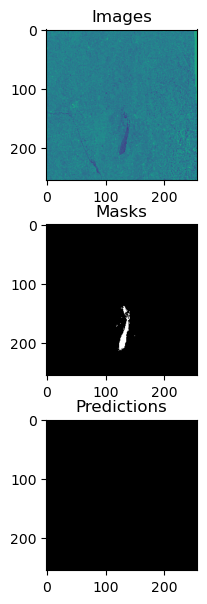

Dice Coefficient: 0.0008756567258387804
Dice Coefficient Lackens: 0.0625


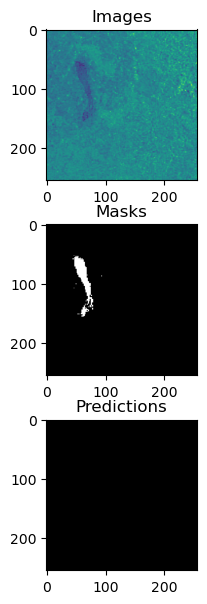

Dice Coefficient: 0.0007429420365951955
Dice Coefficient Lackens: 0.025641025975346565


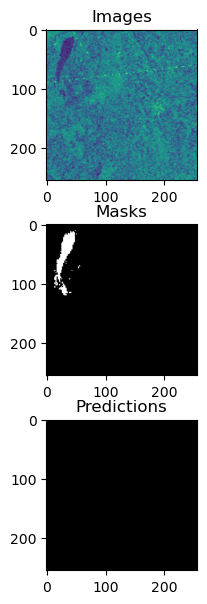

Dice Coefficient: 0.0009569377871230245
Dice Coefficient Lackens: 0.0714285746216774


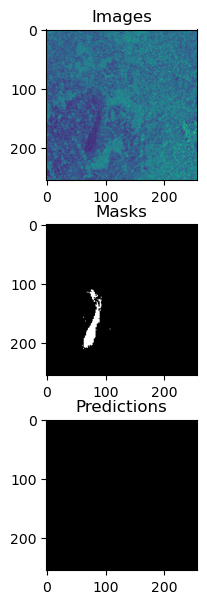

In [32]:
def display_batch(images, masks, pred,lacken_masks):
    print(f"Dice Coefficient: {dice_coeff(pred.to(device), masks.to(device))}")
    print(f"Dice Coefficient Lackens: {dice_coeff(pred.to(device), lacken_masks.to(device))}")

    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    pred = pred.cpu().numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap='gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title('Predictions')

    plt.show()


for images, masks, lacken_masks in testloader:
    with torch.no_grad():

        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()


    display_batch(images, masks, pred,lacken_masks)
